In [112]:
from utils.utils import *
from utils.Algorithms import *
from utils.GraphCreation import *
from utils.Metrics import *
import pandas as pd
np.random.seed(0)

In [113]:
def runResults(matrix, trueclusters, k, algorithms, metrics, mu_SCSR = 5):

    """
    Runs the algorithms and returns a dataframe with the results on the metrics
    
    Parameters
    ----------
    
    matrix (numpy.ndarray) Adjacency matrix of the graph
    true_clusters (list) List of the true clusters
    k (int) Number of target clusters
    algorithms (list) List of algorithms to run
    metrics (list) List of metrics to use

    Returns
    -------
    results (pandas.DataFrame) Dataframe with the results
    """

    results = pd.DataFrame(columns = ['Algorithm'] + [metric.__name__ for metric in metrics]+ ["Run Time"])

    for algorithm in algorithms:
        if algorithm.__name__ == 'SC_SR':
            predictions, run_time = algorithm(matrix, k, true_clusters = trueclusters, mu = mu_SCSR)
            new_line = [algorithm.__name__] + [round(metric(predictions, trueclusters), 2) for metric in metrics] + [round(run_time, 2)]
            results.loc[len(results.index)] = new_line
        else:
            predictions, run_time = algorithm(matrix, k)
            new_line = [algorithm.__name__] + [round(metric(predictions, trueclusters), 2) for metric in metrics] + [round(run_time, 2)]
            results.loc[len(results.index)] = new_line

    results.set_index('Algorithm', inplace = True)

    return results

In [114]:
algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL]
metrics = [Purity, NMI, RI]

# Simple Two-Layer Graph

In [115]:
#On peut faire des seuils pour la connection entre potes
#par exemple
HIGH = 0.8
MEDIUM = 0.5
LOW = 0.3

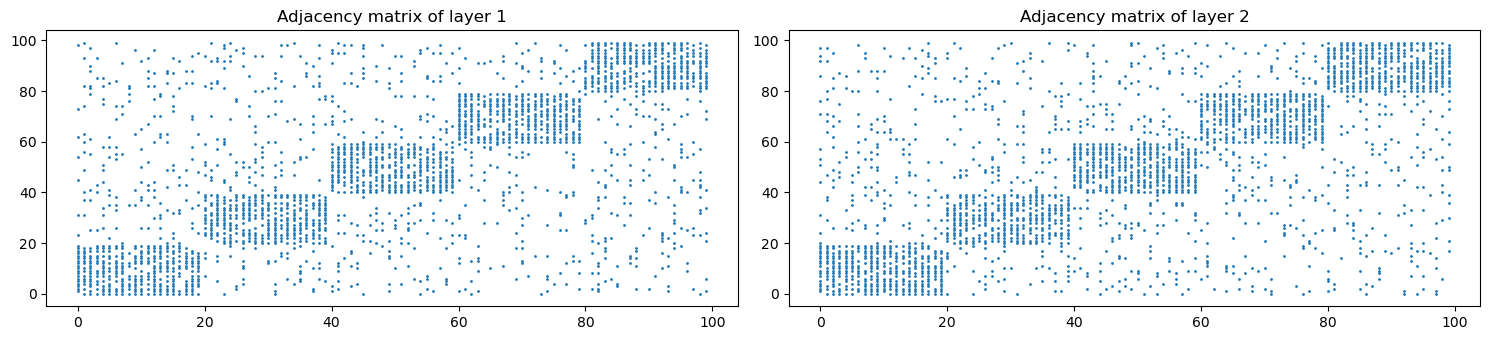

True assignment  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


,Purity,NMI,RI,Run Time
Algorithm,,,,
SC_GED,1.0,1.0,1.0,3.42
SC_SR,1.0,1.0,1.0,0.17
SC_SUM,1.0,1.0,1.0,0.00
SC_AL,1.0,1.0,1.0,0.03
CoR,1.0,1.0,1.0,10.35


In [5]:
n = 100
M = 2
k = 5

p = HIGH
delta = 0.7 #should be between 0 and p ; on peut le varier varier pour avoir une courbe

prob = np.full((k,M), p)
prob_prime = np.full((k,k,M), p-delta)
clusters_size = k*[20]

matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)
print("True assignment ", true_clusters)
results = runResults(matrix, true_clusters, k, algorithms, metrics)
results

# More complicated

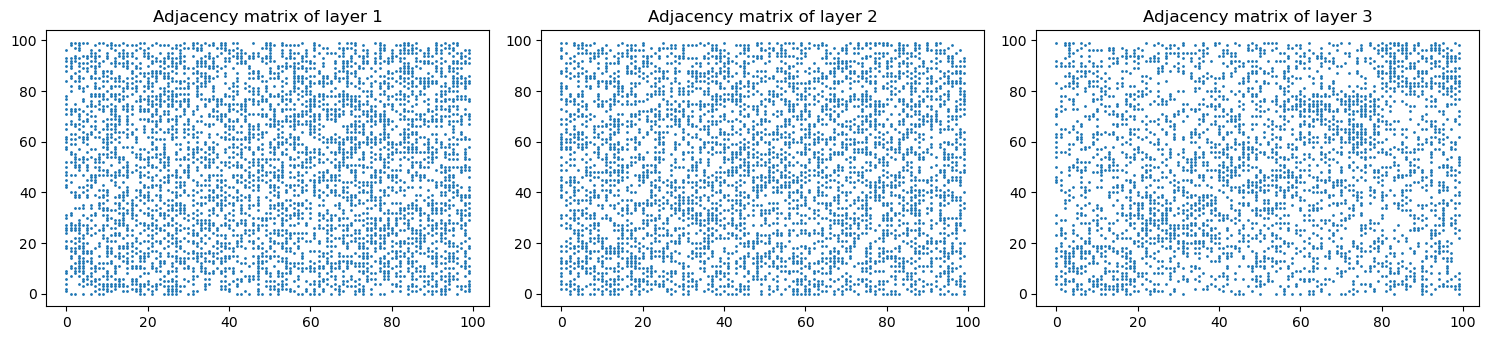

,Purity,NMI,RI,Run Time
Algorithm,,,,
SC_GED,0.29,0.03,0.67,2.40
SC_SR,0.35,0.12,0.70,0.10
SC_SUM,0.50,0.22,0.72,0.00
SC_AL,0.56,0.30,0.76,0.04
CoR,0.31,0.06,0.69,6.42


In [6]:
n = 100
M = 3
k = 5

p = MEDIUM

prob = np.full((k,M),0.5)
#prob[:,2] = np.array(k*[0.8])
#prob[:,3] = np.array(k*[0.8])


prob_prime1 = np.full((k,k),0.4)
prob_prime2 = np.full((k,k),0.4)
#prob_prime3 = np.full((k,k),0.8)
#prob_prime4 = np.full((k,k),0.8)
prob_prime5 = np.full((k,k),0.3)

prob_prime = np.stack((prob_prime1,prob_prime2,prob_prime5),axis=2)
clusters_size = k*[20]

matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)

results = runResults(matrix, true_clusters, k, algorithms, metrics)
results

-Lorsque la premiere couche est + informative que les autres : SC_GED, CoR sont a peu pres égaux, et meilleurs que les 2 autres.

- 5 couches très peu informatives (0.4 contre .35) SC_GED surpassé par SC_SUM (logique, mais pas de bcp).

- 10 couches très peu informatives, même résultat, l'écart ne se creuse pas forcément bcp.

- 3 couches, informatives de manière différente. SC_GED et CoR équivalents, un peu devant les autres mais pas bcp

- 5 couches informatives de manière différente, même constat

- 2 couches de bruit parmi 5 couches. SC_AL, SC_SUM meilleur que les deux autres (et plutot de bcp). (0.38,0.51,0.7,0.35).

- on enlève ces 2 couches de bruits : SC_SUM et SC_AL ont leur résultats qui augmentent (bcp pour le premier), SC_GED inchangé.



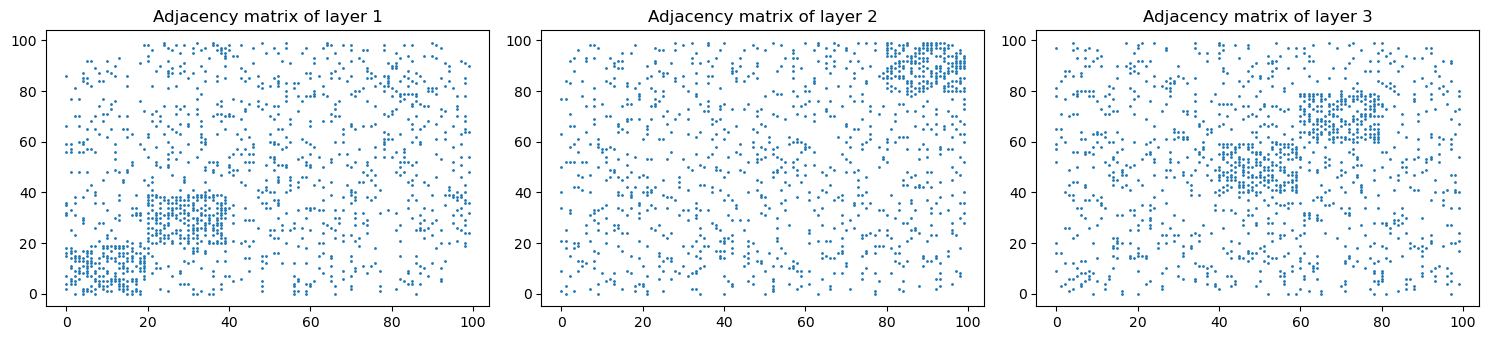

,Purity,NMI,RI,Run Time
Algorithm,,,,
SC_GED,0.58,0.39,0.78,2.47
SC_SR,0.53,0.29,0.76,0.10
SC_SUM,0.72,0.61,0.85,0.00
SC_AL,0.46,0.21,0.72,0.03
CoR,0.53,0.35,0.77,6.61


In [11]:
n = 100
M = 3
k = 5

p = MEDIUM

prob = np.full((k,M),0.5)
prob[:,2] = np.array([0.1, 0.1, 0.5, 0.5, 0.1])
prob[:,1] = np.array([0.1, 0.1, 0.1, 0.1, 0.5])
prob[:,0] = np.array([0.5, 0.5, 0.1, 0.1, 0.1]) #dans la couche, proba que deux mecs du cluster i soient liés


prob_prime1 = np.full((k,k),0.1) #matrice symétrique ; proba que un mec dans i et un mec dans j soient liés
prob_prime2 = np.full((k,k),0.1)
prob_prime3 = np.full((k,k),0.1)

prob_prime = np.stack((prob_prime1,prob_prime2,prob_prime3),axis=2) #shape k,k,M
clusters_size = k*[20]

matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)

results = runResults(matrix, true_clusters, k, algorithms, metrics)
results

# M times the "same" layer

We want here to study the asymptotic behaviour of our different algorithms when $M \rightarrow \infty$ at $\delta$ fixed ; and conversely, at M fixed, the asymptotic behaviour when $\delta \rightarrow 0$. Each layer is generated with the same parameter: each layer conveys the same type of information.

## Fine-tuning of the parameter $\mu = 1/ \lambda$ in SC-SR

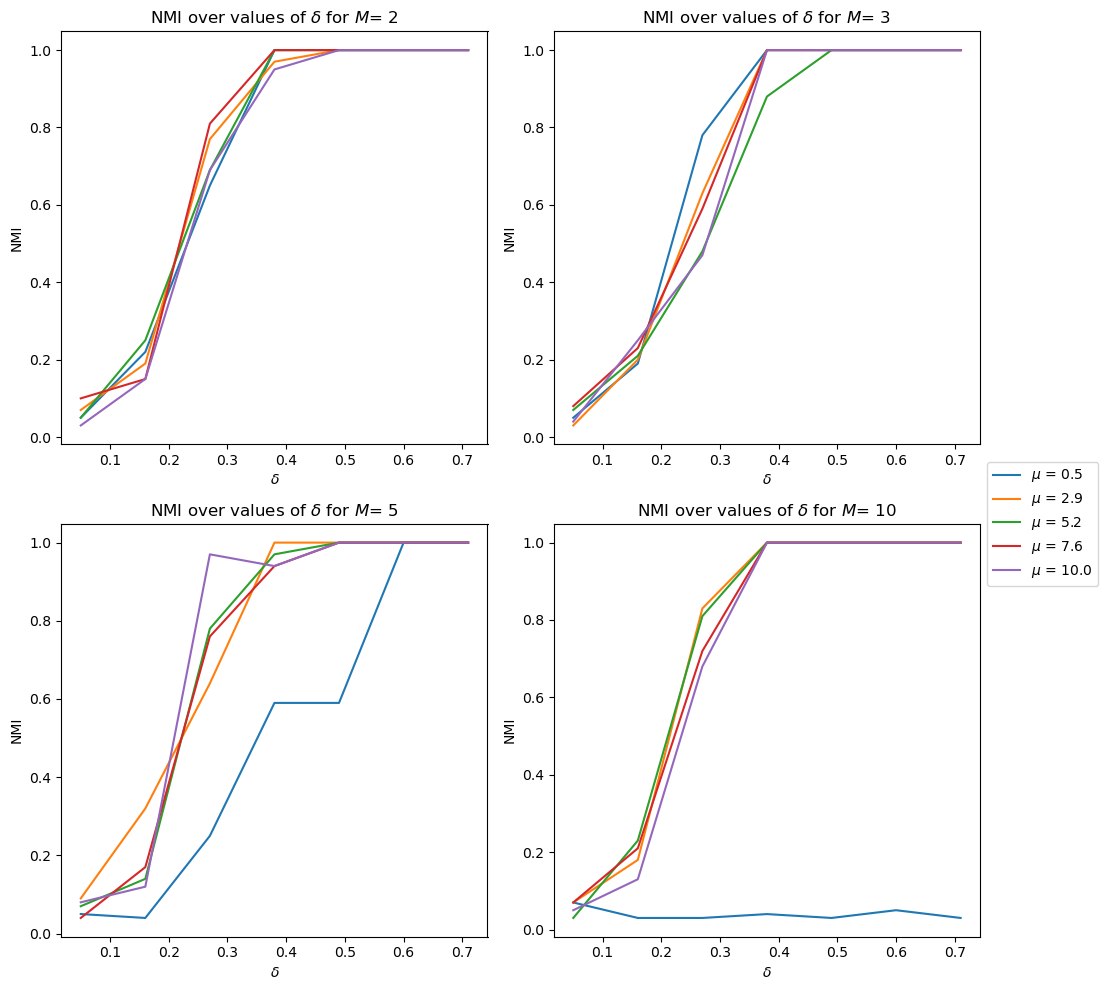

In [31]:
p = HIGH
n = 100
k = 4

mus = np.linspace(0.5, 10, 5)
deltas = np.arange(0.05, p, 0.11)
Ms = [2, 3, 5, 10]

all_res = {}
plt.subplots(figsize = (10, 10))
for idx, M in enumerate(Ms):
    plt.subplot(2, 2, Ms.index(M)+1)
    for mu in mus:
        res = []
        for delta in deltas:
            prob = np.full((k,M), p)
            prob_prime = np.full((k,k,M), p-delta)
            clusters_size = k*[n //k]

            matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
            predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu = mu)
            
            res.append(round(NMI(predictions, true_clusters), 2))

        plt.plot(deltas, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

    plt.title(r'NMI over values of $\delta$ for $M$= {}'.format(M))
    plt.xlabel(r'$\delta$')

    plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()

    
    


## Benchmark

In [32]:
n = 100
p = HIGH
k = 4


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR]
metrics = [Purity, NMI, RI]

Ms = [2, 3, 5, 10]
deltas = np.arange(0.05, p, 0.11)
all_res = {}

for M in Ms:
    for delta in deltas:
        prob = np.full((k,M), p)
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_SCSR = 8)
        print("M = ", M, "delta = ", delta)
        print(results)
        print("\n")
        all_res[M, delta] = results



M =  2 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.03  0.62      0.93
SC_SR        0.42  0.10  0.65      0.13
SC_SUM       0.42  0.11  0.65      0.00
SC_AL        0.47  0.11  0.66      0.03
CoR          0.30  0.01  0.62      5.83


M =  2 delta =  0.16
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.48  0.16  0.67      0.83
SC_SR        0.48  0.16  0.67      0.07
SC_SUM       0.57  0.32  0.68      0.00
SC_AL        0.57  0.32  0.72      0.03
CoR          0.31  0.02  0.63      6.06


M =  2 delta =  0.27
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.60  0.34  0.72      0.91
SC_SR        0.72  0.50  0.79      0.07
SC_SUM       0.96  0.90  0.96      0.00
SC_AL        0.97  0.91  0.97      0.03
CoR          0.45  0.21  0.68      6.03


M =  2 delta =  0.38
           Purity   NMI    RI  Run Time
Algorithm                     

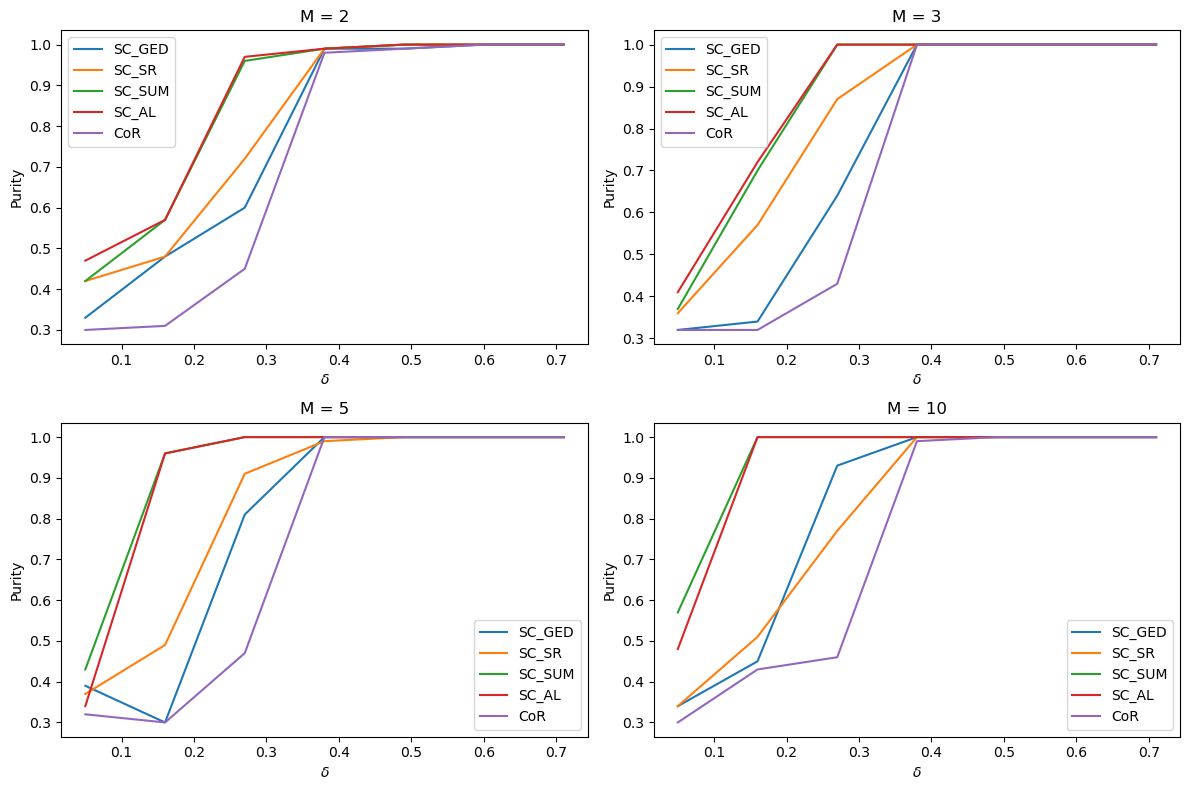

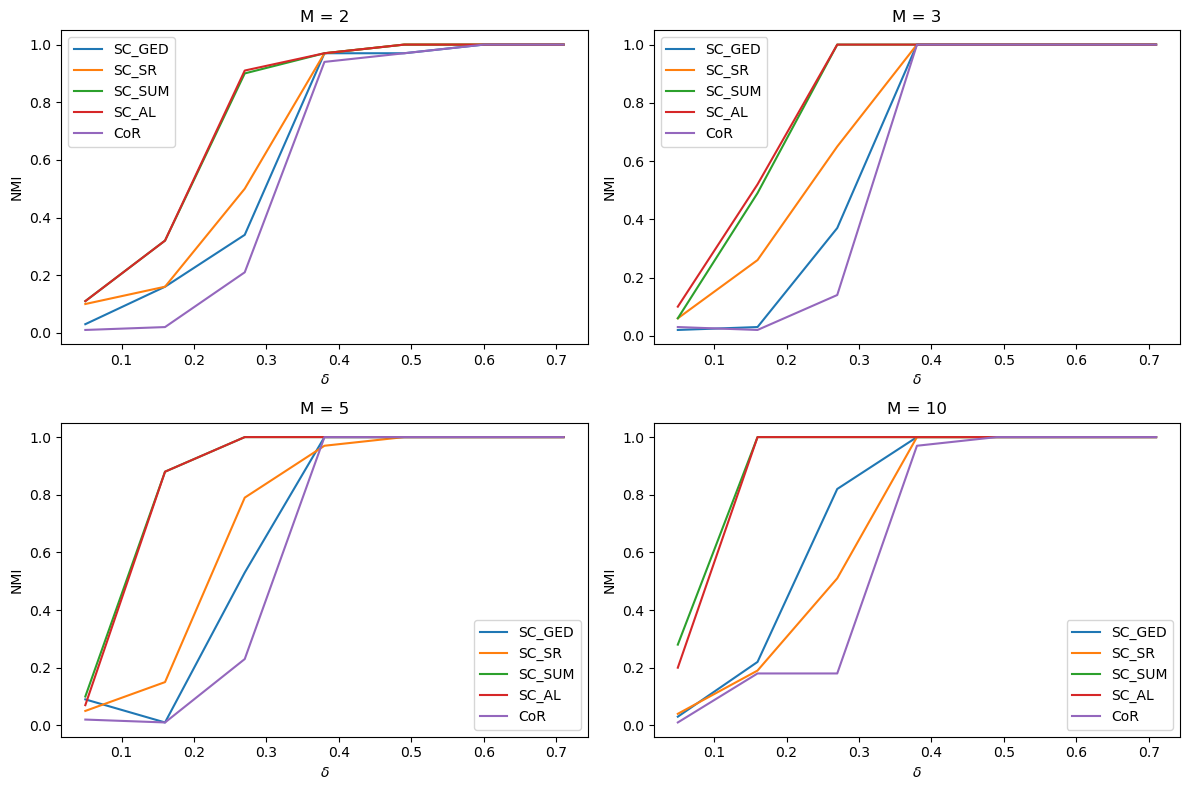

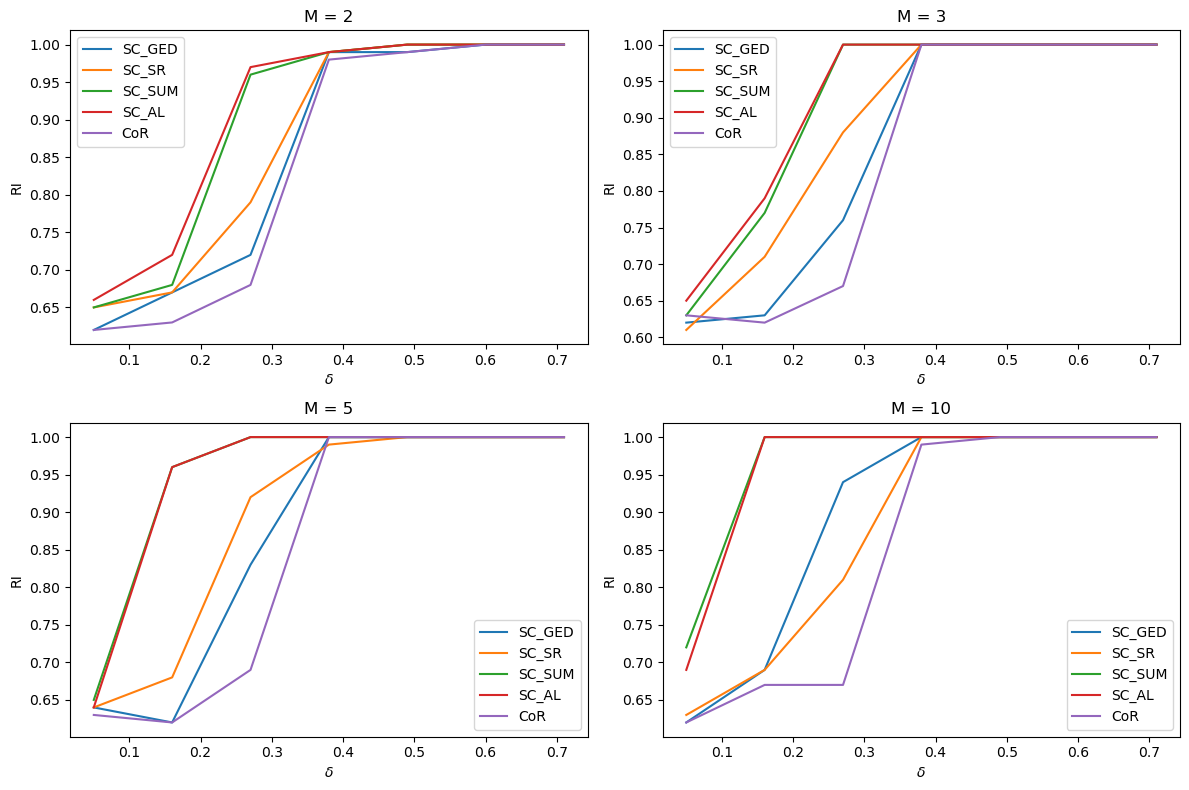

In [33]:
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    for i, M in enumerate(Ms):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            data = [all_res[M, delta][metric.__name__].loc[algorithm.__name__] for delta in deltas]
            plt.plot(deltas, data, label = algorithm.__name__)

        plt.title("M = " + str(M))
        plt.xlabel(r"$\delta$")
        plt.ylabel(metric.__name__)
        plt.legend()

    plt.tight_layout()
    plt.show()


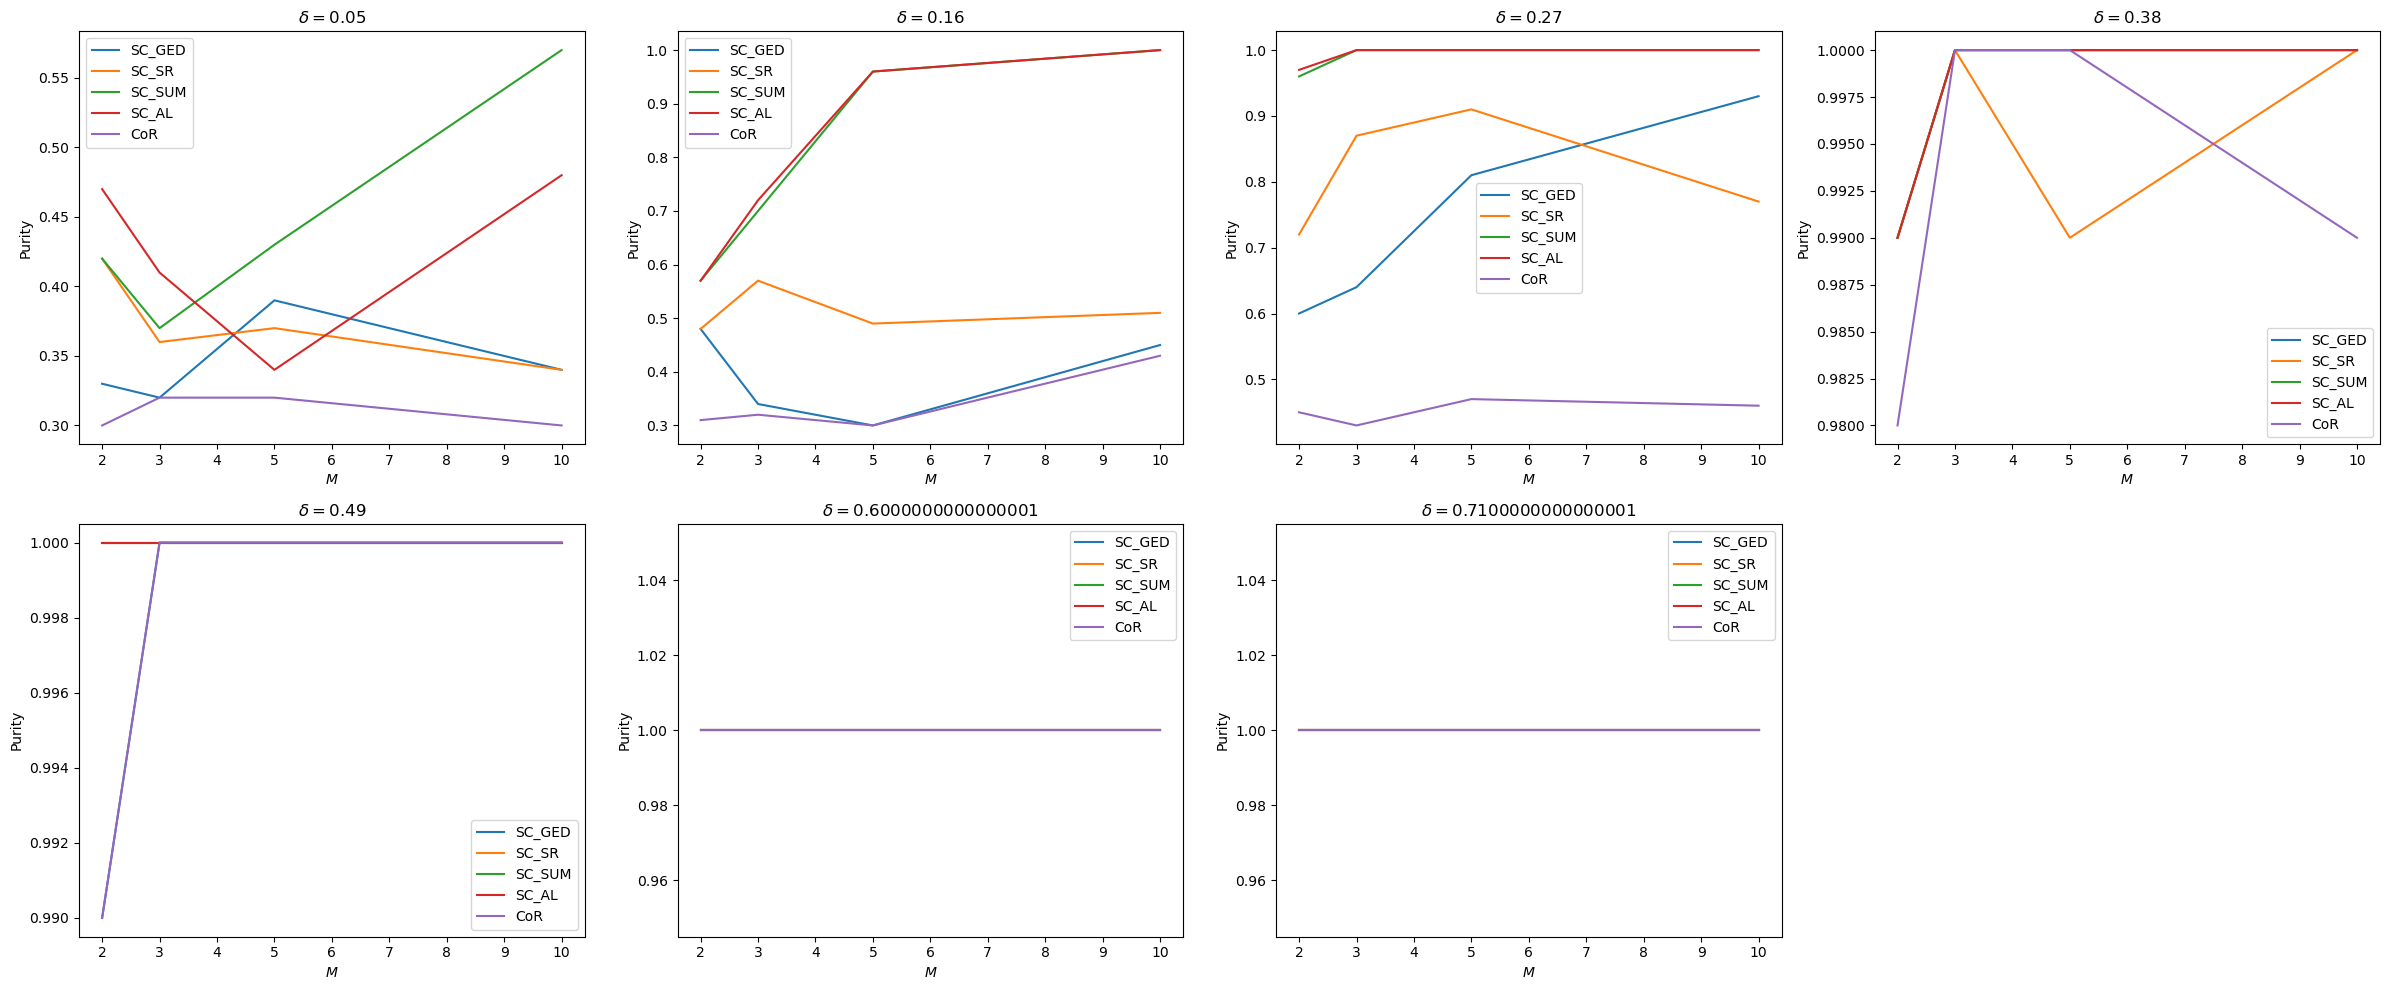

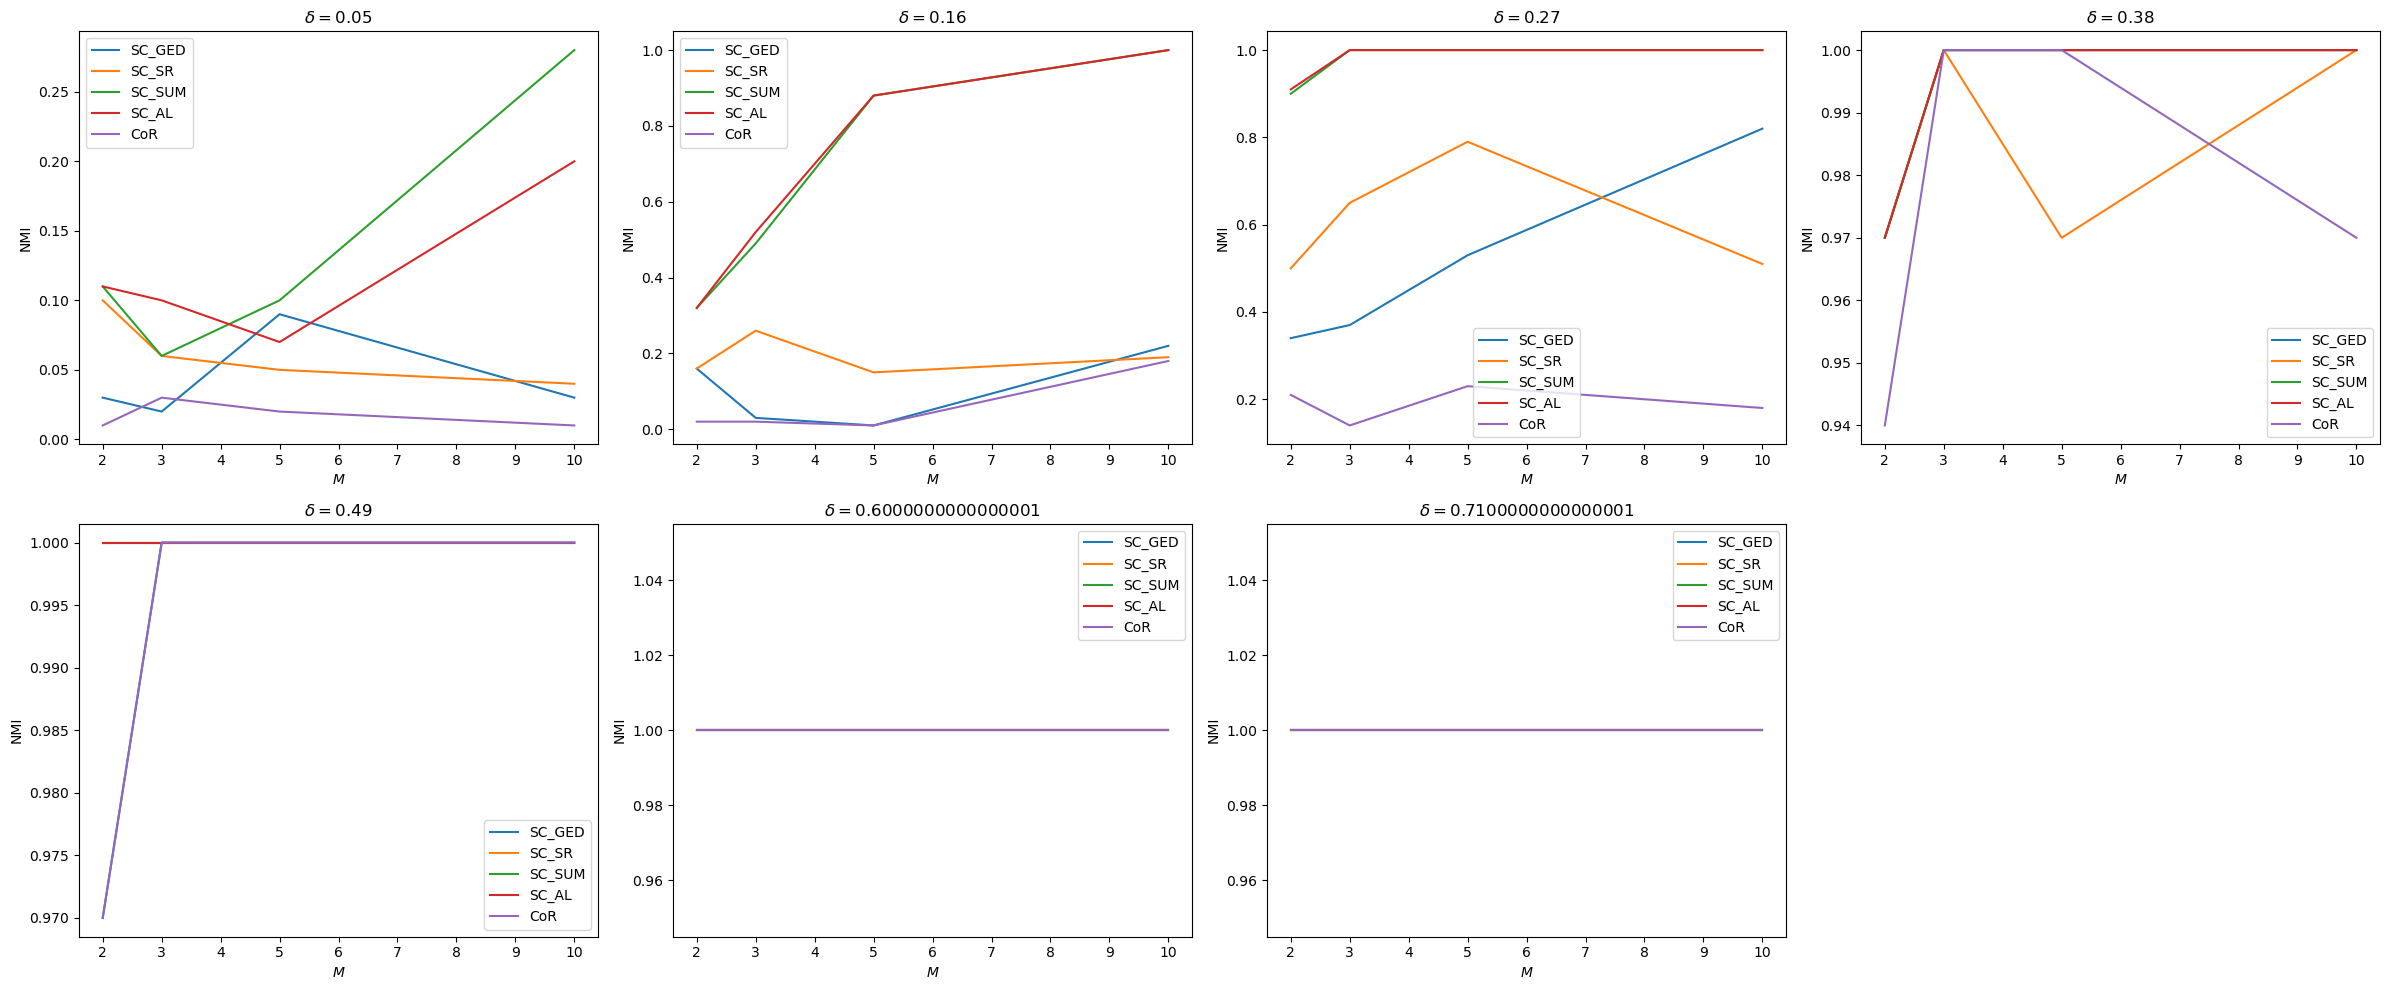

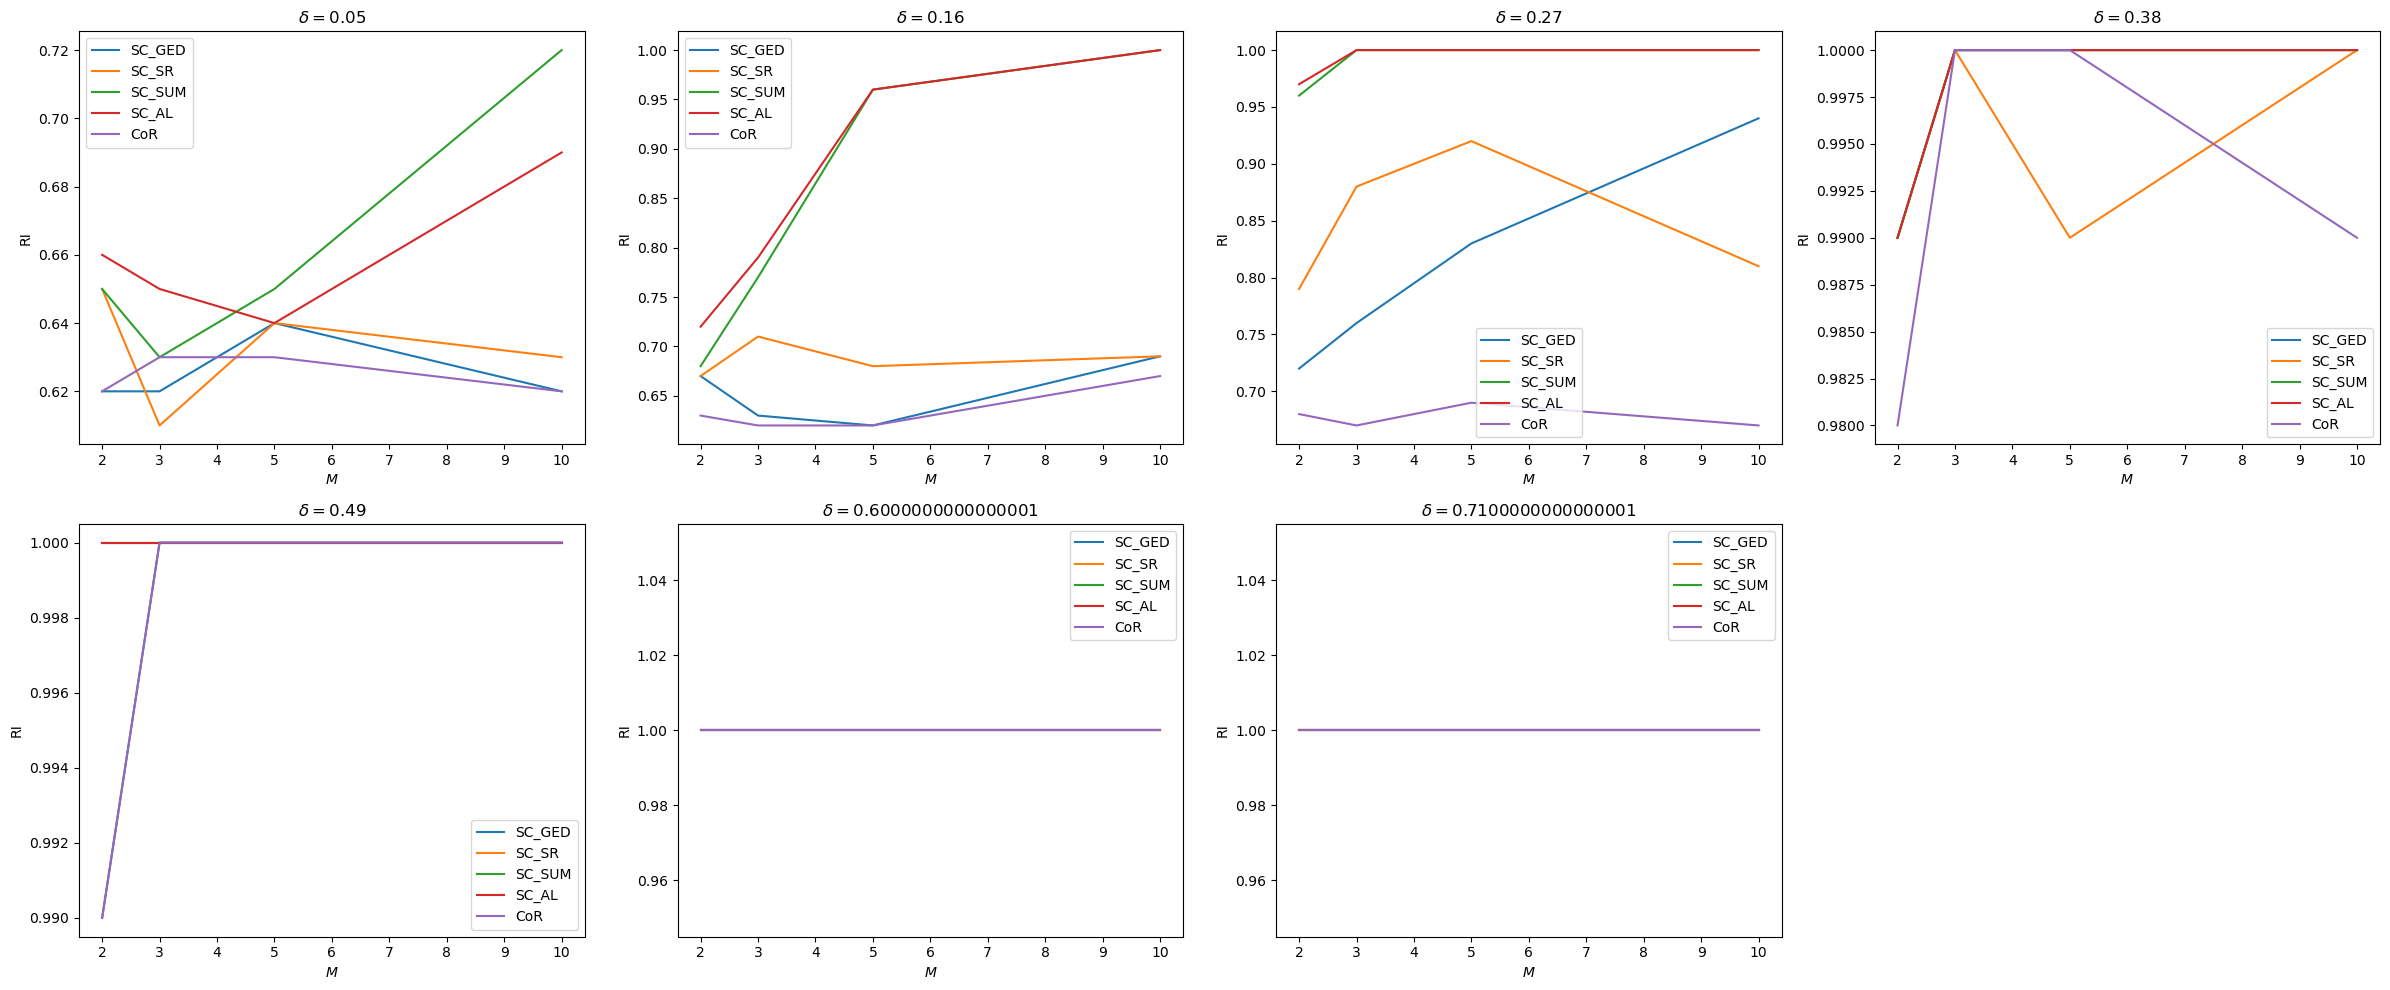

In [41]:
for metric in metrics:   
    plt.figure(figsize = (24, 10))
    for i in range(len(deltas)):
        plt.subplot(2, 4, i+1)
        delta = deltas[i]
        for algorithm in algorithms:
            data = [all_res[M, delta][metric.__name__].loc[algorithm.__name__] for M in Ms]
            plt.plot(Ms, data, label = algorithm.__name__)

        plt.title(r"$\delta = $" + str(delta))
        plt.xlabel(r"$M$")
        plt.ylabel(metric.__name__)
        plt.legend()

    plt.tight_layout()
    plt.show()

SC_AL and SC_SUM : kind of convergence when M is increasing, while the 3 others are decreasing ! They are getting better and better.
CoR in an underperformer, SC_SR struggles when M is increasing (leads before and gets behind SC_GED for M = 10).

--> SC_AL and SC_SUM are better for (over ?)-fitting ! in a very simple case

In terms of runtime, CoR is the worst. SC_GED gets terrible when M increases. 


## Each cluster per layer

[[0.8 0.1 0.1]
 [0.8 0.1 0.1]
 [0.1 0.8 0.1]
 [0.1 0.8 0.1]
 [0.1 0.1 0.8]]


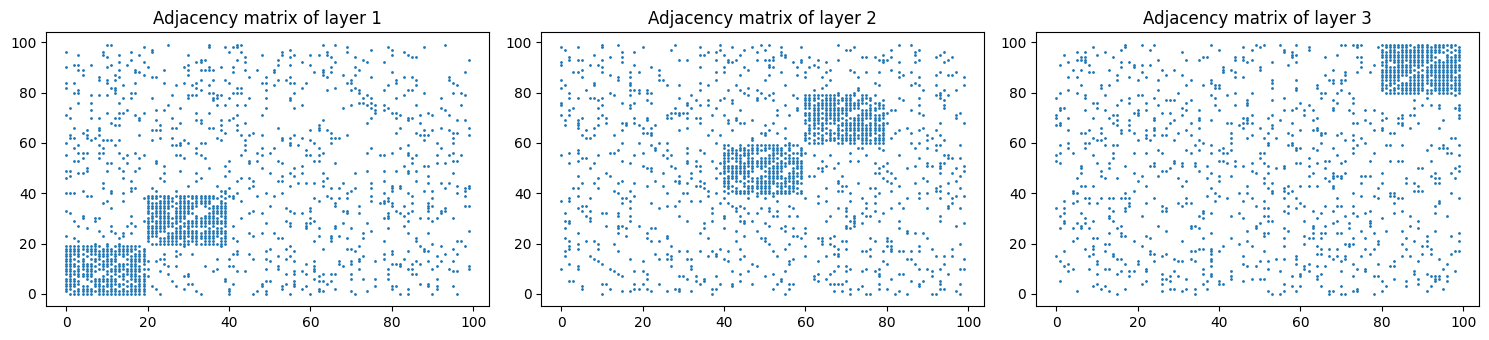

In [108]:
n = 100
M = 3
k = 5

p = 0.8
delta = 0.7
prob = np.full((k,M), p-delta)
prob[:2,0] = p
prob[2:4,1] = p
prob[4,2] = p
print(prob)
prob_prime = np.full((k,k,M), p-delta)


clusters_size = k*[20]


matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)



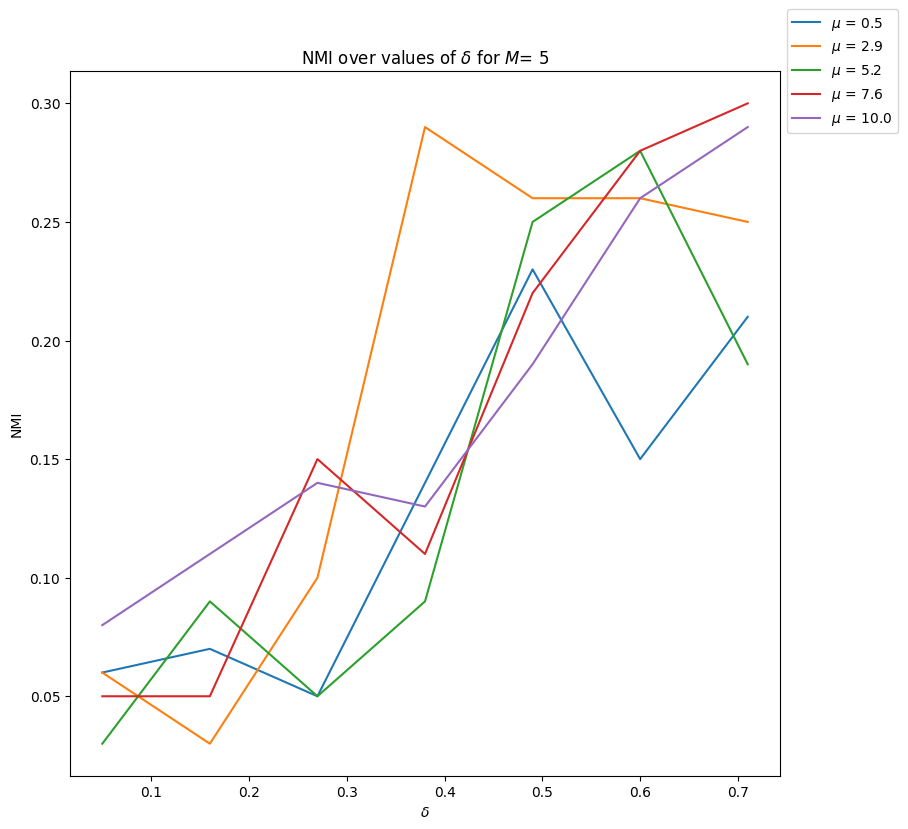

In [57]:
p = HIGH
n = 100
k = 5
M = 5

mus = np.linspace(0.5, 10, 5)
deltas = np.arange(0.05, p, 0.11)
all_res = {}
plt.subplots(figsize = (8, 8))

for mu in mus:
    res = []
    for delta in deltas:
        prob = np.full((k,M), p-delta)
        for i in range(k):
            prob[i,i] = p 
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu = mu)
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(deltas, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

plt.title(r'NMI over values of $\delta$ for $M$= {}'.format(M))
plt.xlabel(r'$\delta$')

plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


We take $\mu = 7.6$. 

In [58]:
mu_SCSR = 7.6

## Benchmark

In [94]:
n = 100
p = HIGH
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.11)
all_res = {}

for delta in deltas:
    print("Next iteration, delta = ",delta)
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_SCSR = mu_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

Next iteration, delta =  0.05


M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.34  0.08  0.69     14.61
SC_SR        0.32  0.05  0.68      0.72
SC_SUM       0.29  0.04  0.68      0.00
SC_AL        0.30  0.05  0.69      0.22
CoR          0.30  0.04  0.68     24.03


Next iteration, delta =  0.16
M =  5 delta =  0.16
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.30  0.04  0.69     12.08
SC_SR        0.29  0.04  0.68      1.71
SC_SUM       0.33  0.07  0.69      0.00
SC_AL        0.32  0.06  0.69      0.21
CoR          0.36  0.11  0.70     27.37


Next iteration, delta =  0.27
M =  5 delta =  0.27
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.06  0.69     14.30
SC_SR        0.34  0.09  0.69      0.61
SC_SUM       0.34  0.08  0.67      0.00
SC_AL        0.34  0.11  0.69      0.16
CoR          0.33  0.06  0.69     34.85


Next iteration, delta =  0.38
M

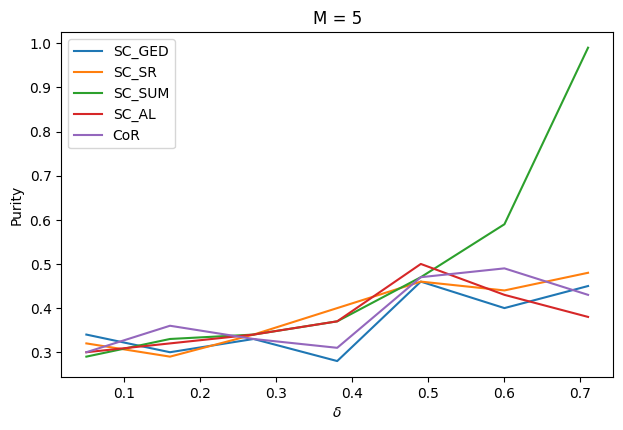

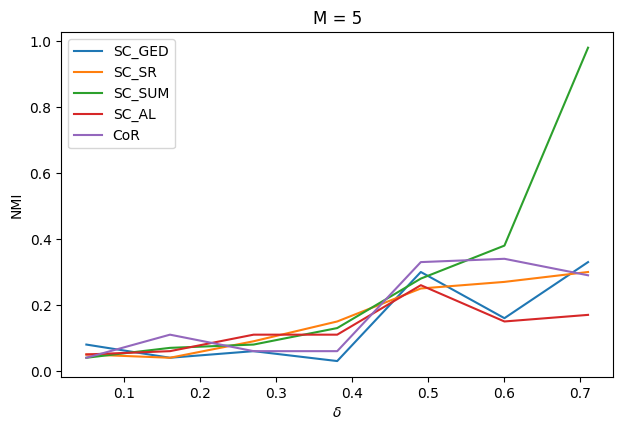

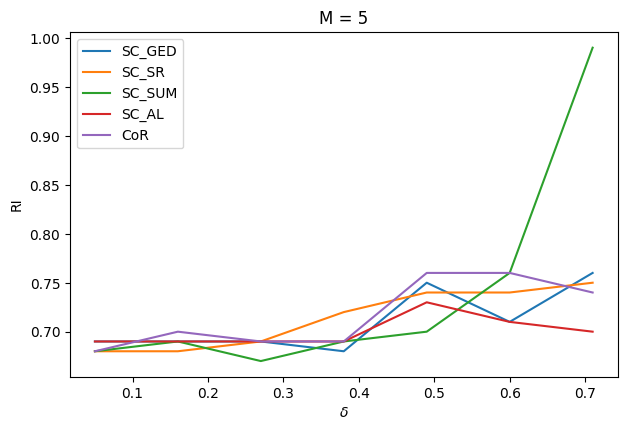

In [96]:
deltas = np.arange(0.05, p, 0.11)
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    plt.subplot(2, 2, i+1)
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [100]:
n = 100
p = MEDIUM
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.05)
all_res = {}

for delta in deltas:
    print("Next iteration, delta = ",delta)
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_SCSR = mu_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

Next iteration, delta =  0.05
M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.34  0.06  0.69     21.79
SC_SR        0.28  0.04  0.68      0.41
SC_SUM       0.29  0.06  0.67      0.00
SC_AL        0.30  0.04  0.69      0.15
CoR          0.33  0.07  0.69     27.28


Next iteration, delta =  0.1
M =  5 delta =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.26  0.03  0.68     17.95
SC_SR        0.38  0.13  0.71      0.57
SC_SUM       0.34  0.10  0.68      0.00
SC_AL        0.33  0.07  0.69      0.14
CoR          0.30  0.05  0.69     28.50


Next iteration, delta =  0.15000000000000002
M =  5 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.32  0.05  0.69     23.11
SC_SR        0.35  0.10  0.69      0.90
SC_SUM       0.33  0.08  0.67      0.00
SC_AL        0.37  0.09  0.69      0.44
CoR          0.

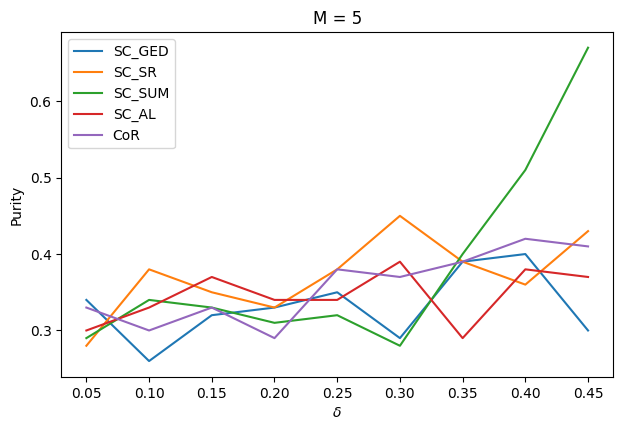

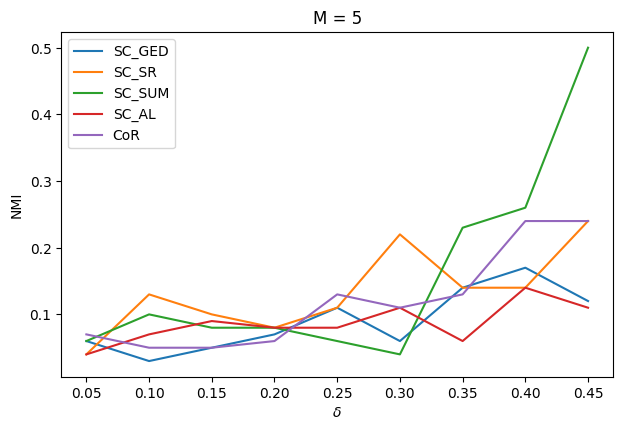

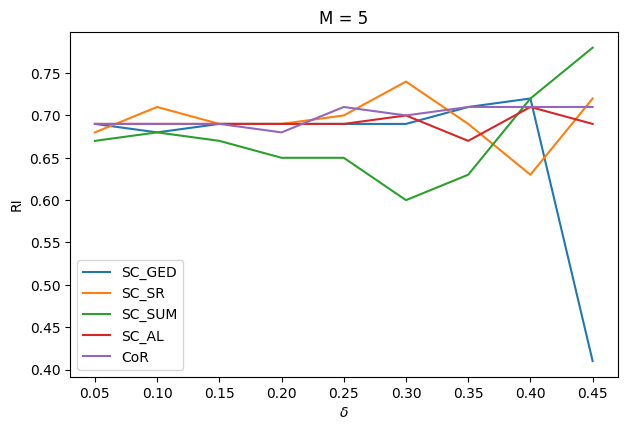

In [102]:
i = 1
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    plt.subplot(2, 2, i+1)
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [110]:
n = 100
p = HIGH
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.1)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:2,0] = p
    prob[2:4,1] = p
    prob[4,2] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_SCSR = mu_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

M =  3 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.06  0.69      6.52
SC_SR        0.33  0.07  0.69      0.50
SC_SUM       0.28  0.06  0.69      0.00
SC_AL        0.32  0.07  0.68      0.19
CoR          0.32  0.04  0.69     29.50


M =  3 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.32  0.07  0.69      6.01
SC_SR        0.28  0.04  0.68      0.28
SC_SUM       0.34  0.07  0.68      0.00
SC_AL        0.35  0.07  0.69      0.10
CoR          0.30  0.05  0.69     31.00


M =  3 delta =  0.25000000000000006
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.30  0.05  0.69      8.42
SC_SR        0.37  0.14  0.70      0.42
SC_SUM       0.30  0.07  0.65      0.00
SC_AL        0.34  0.11  0.69      0.18
CoR          0.29  0.03  0.68     29.18


M =  3 delta =  0.35000000000000003
           Purity   NMI  

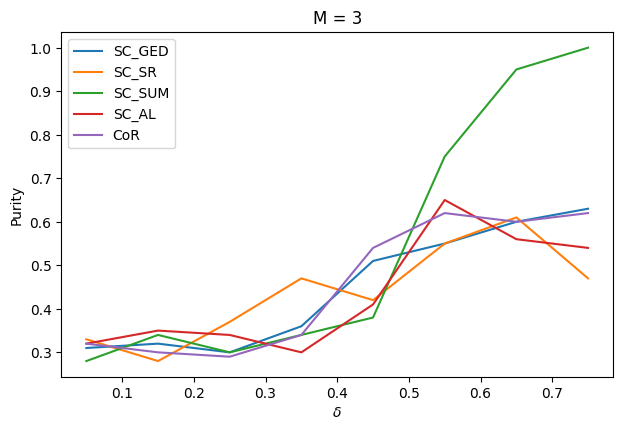

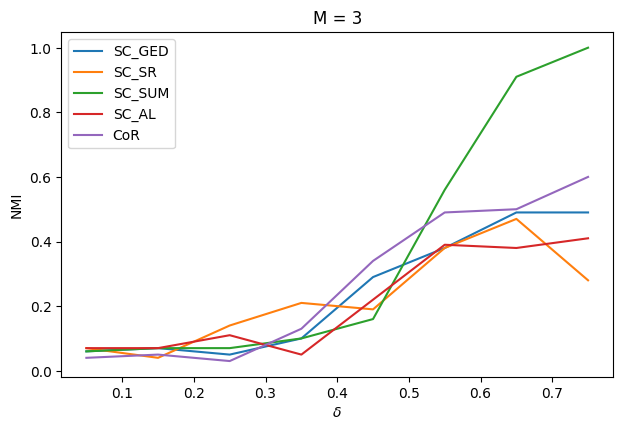

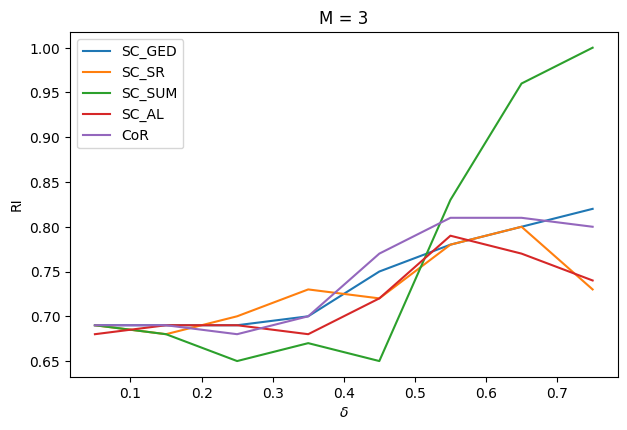

In [111]:
i = 1
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    plt.subplot(2, 2, i+1)
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [118]:
n = 100
p = HIGH
k = 5
M = 2


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.1)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:3,0] = p
    prob[3:,1] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_SCSR = mu_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

M =  2 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.07  0.69      4.60
SC_SR        0.30  0.06  0.67      0.21
SC_SUM       0.32  0.07  0.66      0.00
SC_AL        0.34  0.09  0.69      0.10
CoR          0.31  0.07  0.69     27.64


M =  2 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.38  0.09  0.69      4.41
SC_SR        0.38  0.14  0.71      0.31
SC_SUM       0.30  0.08  0.61      0.00
SC_AL        0.31  0.06  0.68      0.10
CoR          0.32  0.06  0.69     27.88


M =  2 delta =  0.25000000000000006
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.34  0.12  0.70      5.16
SC_SR        0.36  0.11  0.70      0.22
SC_SUM       0.33  0.12  0.54      0.00
SC_AL        0.44  0.20  0.72      0.12
CoR          0.31  0.06  0.69     26.63


M =  2 delta =  0.35000000000000003
           Purity   NMI  

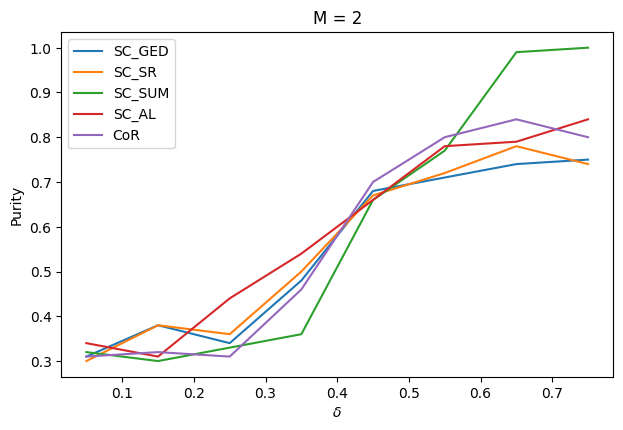

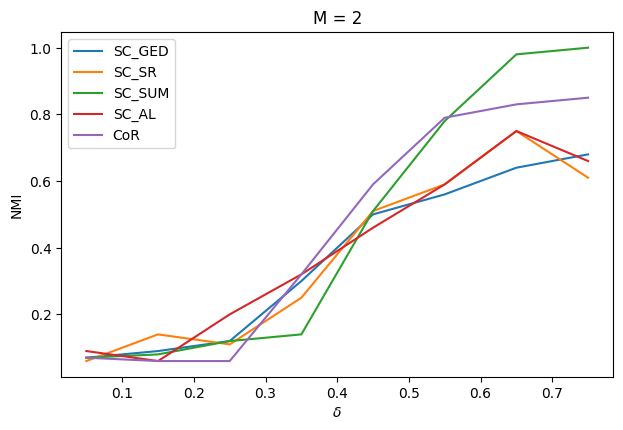

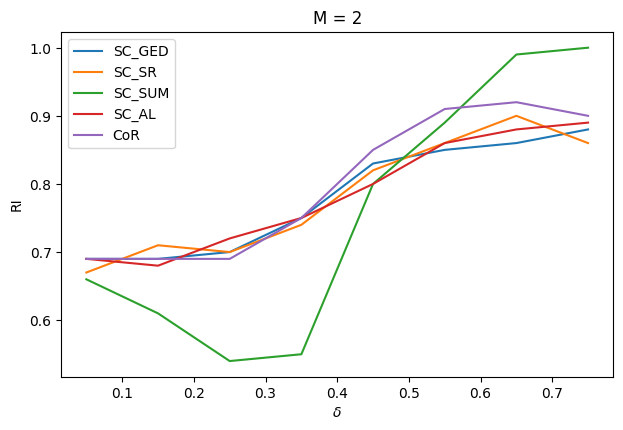

In [119]:
i = 1
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    plt.subplot(2, 2, i+1)
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

    plt.tight_layout()
    plt.show()